## Neural Networks (2022-2023)
### Lab session 2: Convolutional neural networks

In [ ]:
# We will use torchmetrics for computing the accuracy: https://torchmetrics.readthedocs.io/
%pip install torchmetrics --quiet

     |████████████████████████████████| 529 kB 25.0 MB/s 


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
import torchmetrics
import torchvision
from torchvision import transforms as T

In [ ]:
import tqdm
import matplotlib.pyplot as plt

## Step 1: Loading the data

For this lab session we will use KMNIST, which is a simple drop-in replacement for MNIST: http://codh.rois.ac.jp/kmnist/index.html.en. The input is a (28,28) black-and-white image, which has to be classified into 10 different classes.

In [ ]:
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [ ]:
# A Dataset is fundamentally an iterator over the elements of the dataset.
# You can read more about its functionality here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
len(train_data)

60000

In [ ]:
# Alternative way to get the first element: image, label = next(iter(train_data))
for image, label in train_data:
  break

In [ ]:
print(type(image))
print(label)

<class 'PIL.Image.Image'>
8


## Step 2: Pre-processing the data

The simplest way to pre-process the input data (normalization, data augmentation, ...) is to define one or more transformations when instantiating the dataset: https://pytorch.org/vision/stable/transforms.html. 

In [ ]:
# Simple transformation that converts the PIL image to a PyTorch array
T.ToTensor()(image).shape

torch.Size([1, 28, 28])

In [ ]:
# T.Compose allows to chain together multiple transformations
train_transforms = T.Compose([
    T.RandomRotation(15),
    T.ToTensor()
])

In [ ]:
# This loads data with both data conversion & a simple data augmentation step.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=train_transforms)

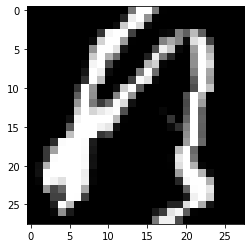

In [ ]:
# Try this multiple times: we are loading the same image, but with a different
# rotation each time.
image, label = next(iter(train_data))
plt.imshow(image[0], cmap='gray')

In [ ]:
# Loaders are used to shuffle, batch, and possibly sample the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
xb, yb = next(iter(train_loader))

In [ ]:
# Shape is now (batch_size, channels, height, width)
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
# Target shape is now (batch_size,)
yb

tensor([3, 1, 7, 1, 3, 7, 1, 2, 6, 6, 6, 7, 9, 1, 0, 4, 2, 9, 5, 7, 9, 6, 9, 5,
        9, 4, 5, 3, 3, 2, 9, 2, 5, 1, 2, 7, 3, 8, 1, 8, 0, 4, 8, 5, 8, 8, 5, 6,
        4, 8, 0, 6, 2, 7, 8, 9, 7, 2, 6, 8, 9, 0, 0, 6])

In [ ]:
# Loading the test data is similar, but (a) we do not apply data augmentation,
# and (b) we do not shuffle when building the mini-batches.
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Interlude: Using layers in PyTorch

See the list of all available layers here: https://pytorch.org/docs/stable/nn.html.

In [ ]:
# 1 input channel, 16 output channels, 5x5 kernel size
conv2d = nn.Conv2d(1, 16, 5, padding=2, stride=2)

In [ ]:
conv2d(xb).shape

torch.Size([64, 16, 14, 14])

In [ ]:
nn.MaxPool2d(2)(xb).shape

torch.Size([64, 1, 14, 14])

In [ ]:
# parameters() returns a generator over parameters;
# named_parameters() returns a generator listing also the names of the parameters.
for n, p in conv2d.named_parameters():
  print(n)
  print(p.shape)

weight
torch.Size([16, 1, 5, 5])
bias
torch.Size([16])


In [ ]:
dropout = nn.Dropout(0.4)

In [ ]:
x = torch.randn((3, 2))

In [ ]:
# Training mode: some data is dropped, the other values are rescaled (inverted dropout).
dropout.train()
print(x)

tensor([[ 1.0399,  0.2331],
        [ 0.0083,  1.8913],
        [ 0.6835, -0.3812]])


In [ ]:
# Evaluation mode: nothing happens.
dropout.eval()
dropout(x)

tensor([[ 1.0399,  0.2331],
        [ 0.0083,  1.8913],
        [ 0.6835, -0.3812]])

In [ ]:
# No parameters!
for p in dropout.parameters():
  print(p)

In [ ]:
batch_norm = nn.BatchNorm2d(16)

In [ ]:
# Batch normalization has two set of parameters (alpha and beta in the slides).
for p in batch_norm.parameters():
  print(p.shape)
  print(p)

torch.Size([16])
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)
torch.Size([16])
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)


In [ ]:
# Buffers are additional tensors that should not be trained (in this case,
# the running statistics of mean and variance).
for p in batch_norm.buffers():
  print(p.shape)
  print(p)

torch.Size([16])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([16])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
torch.Size([])
tensor(0)


In [ ]:
# Train mode: data is normalized, and running statistics are updated (try to run
# again the previous cell).
batch_norm.train()
batch_norm(conv2d(xb)).mean([0,2,3])

tensor([ 2.3416e-08,  1.2164e-08,  1.3685e-08,  1.3685e-08,  2.1287e-09,
         1.5205e-09,  9.7314e-09,  5.4435e-08, -5.3218e-09, -3.9534e-09,
        -1.4217e-08,  5.6259e-08, -6.3558e-08, -6.0821e-09, -2.3112e-08,
         1.7220e-08], grad_fn=<MeanBackward1>)

In [ ]:
# Evaluation mode: the running statistics are applied instead of the computed
# ones. Since we only ran the model once, the statistics are still not very good
# estimators of the true mean and variance of this mini-batch.
batch_norm.eval()
batch_norm(conv2d(xb)).mean([0,2,3])

tensor([ 0.0348, -0.2177,  0.0540,  0.1182, -0.0204,  0.0408,  0.0737, -0.2970,
        -0.0547, -0.2681,  0.0150,  0.0599,  0.2960,  0.1169, -0.0661, -0.0936],
       grad_fn=<MeanBackward1>)

## Part 3: Building a convolutional neural network

Extending the `nn.Module` class is the most general way to define a neural network in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Module.html.

In [ ]:
class SimpleCNN(nn.Module):
    # Note: this is a variant of the LeNet-5 network.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*7*7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        # Output shape: (batch_size, 32, 7, 7)
        x = x.reshape((-1, 32*7*7))
        # Alternative with global average pooling: x = x.mean([2, 3])
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

In [ ]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# We need to move the SimpleCNN model to the device immediately
cnn = SimpleCNN().to(device)

In [ ]:
# Note: we also need to move data when asking for a prediction
cnn(xb.to(device)).shape

torch.Size([64, 10])

In [ ]:
# We have all methods we saw before: parameters, named_parameters, buffers, train, eval, ...
len(list(cnn.parameters()))

12

## Part 4: Training and evaluating the network

In [ ]:
def accuracy(net, loader, device):
  # A function that aggregates the accuracy over all mini-batches in the loader.
  # See here for a quick-start on torchmetrics: https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html.
  acc = torchmetrics.Accuracy().to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = cnn(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [ ]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(cnn, test_loader, device)

tensor(0.1114, device='cuda:0')

In [ ]:
# Note: it is important to move the CNN to the device before initializing the optimizer,
# since the optimizer also has a state that must be moved to the GPU.
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())

In [ ]:
for epoch in range(3):
  
  cnn.train()
  for xb, yb in tqdm.tqdm(train_loader):
    
    xb, yb = xb.to(device), yb.to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    l = loss(ypred, yb)
    l.backward()
    opt.step()

  cnn.eval()
  print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')

100%|██████████| 938/938 [00:11<00:00, 79.77it/s]


Accuracy at epoch 0: 0.8855999708175659


100%|██████████| 938/938 [00:11<00:00, 79.06it/s]


Accuracy at epoch 1: 0.9258999824523926


100%|██████████| 938/938 [00:11<00:00, 79.68it/s]


Accuracy at epoch 2: 0.9280999898910522


## Exercises

1. Can you add L2 regularization to the loss? Hint: you can use the `parameters()` iterator to loop over the parameters and compute the L2 norm for each (or even better, exclude the biases).
2. You can try experimenting with more advanced data augmentation pipelines. For example, torchvision has [advanced data augmentation policies](https://pytorch.org/vision/stable/transforms.html#generic-transforms), or you can check the [Albumentations](https://albumentations.ai/docs/) library.
3. You can check the [Performance tuning](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) guide for many interesting tricks to speed-up computations; these include for our case (a) optimizing the DataLoader, (b) encapsulating `accuracy` in a `torch.no_grad` decorator, (c) removing biases from the convolutional layers (since they are followed by a batch normalization layer), (d) enabling the "channels last" format, and (e) using the PyTorch JIT compiler.
4. Can you add residual connections? It's very simple in this case, and it probably will not improve performance very much.
5. [Composer](https://github.com/mosaicml/composer) is an interesting library to apply transformations to speed up training; as an example, you can try adding CutMix to the data loading.
6. Can you add early stopping? Note: you need a validation set + a check at the end of every epoch.
7. You can try [fine-tuning an existing model](https://pytorch.org/vision/stable/models.html) instead of building one from scratch. In this case, you need to preprocess the images to an RGB format.